# STM Data Analysis

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from time import perf_counter
from scipy import integrate
from scipy.special import airy
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

In [2]:
ElectronMass = 9.1093837e-31 # [kg]
ElectronCharge = 1.60217663e-19 # [C]
hbar = 1.054571817e-34 # [Js]

magnitude = lambda x: np.linalg.norm(x)*np.linalg.norm(x)

In [3]:
class DataAnalysis:
    ParticleRadius = 1e-10
    TipHeight = 5*ParticleRadius
    

    
    def __init__(self):
        """
        Initalises the class.
        
        Member variables:
            - numSamples:int: The number of points sampled.
            - maxNumElectrons:int: The maximum number of electrons attempting to tunnel.
            - numReadings:int: The number of proportions to measure.
            - bounds:tuple: The upper and
        """
        # Load positions
        with open(r"C:\Users\02dba\Documents\Home\C++\STM uncertainty calculation\systemConditions.txt",
                  'r') as file:
            # https://stackoverflow.com/questions/19056125/reading-a-file-into-a-multidimensional-array-with-python
            lines = [line.split(':')[1][:-1] for line in file]


        self.numSamples = int(lines[0])
        self.maxNumElectrons = int(lines[1])
        self.numReadings = int(lines[2])
        self.bounds = (float(lines[3]), float(lines[4])) # [m]
        self.workFunction = float(lines[5])*ElectronCharge # [J]
        self.bias = float(lines[6])*ElectronCharge # [J]
        self.energy = float(lines[7])*ElectronCharge # [J]
        
        with open(r"C:\Users\02dba\Documents\Home\C++\STM uncertainty calculation\positions.txt",
                  'r') as file:
            # https://stackoverflow.com/questions/19056125/reading-a-file-into-a-multidimensional-array-with-python
            lines = [line.split(',') for line in file]
            
        self.positions = np.asarray(lines, dtype=float)

        with open(r"C:\Users\02dba\Documents\Home\C++\STM uncertainty calculation\samples.txt",
                  'r') as file:
            # https://stackoverflow.com/questions/19056125/reading-a-file-into-a-multidimensional-array-with-python
            lines = [line.split(',')[:-1] for line in file]
            
        self.experimentalHeights = self.TipHeight - np.asarray(lines, dtype=float)
                
        with open(r"C:\Users\02dba\Documents\Home\C++\STM uncertainty calculation\proportionTunnelled.txt",
                  'r') as file:
            # https://stackoverflow.com/questions/19056125/reading-a-file-into-a-multidimensional-array-with-python
            lines = [line.split(',')[:-1] for line in file]
        
        self.proportionTunnelled = np.asarray(lines, dtype=float)
        
        self.k1 = np.sqrt(2*ElectronMass*self.energy) / hbar
        self.k3 = np.sqrt(2*ElectronMass*(self.energy + self.bias)) / hbar
        
        
        self.actualHeights = self.height()
        
        
    def height(self, x:np.ndarray=None, y:np.ndarray=None):
        """
        Uses an exact formula for the heights over an infinite domain.
    
        Inputs:
            - x:np.ndarray=None: x-coords of samples.
            - y:np.ndarray=None: y-coords of samples.

        Outputs:
            - z2D:np.ndarray: Heights for each pair of coords.
        """

        if x is None and y is None:
            x = self.positions[:, 0]
            y = self.positions[:, 1]
        


        verticalSeparation = np.sin(np.pi/3)
        verticalOffset = 0.5
        horizontalOffset = 1.
        gap = 4.

        r = np.hypot(((y/self.ParticleRadius - verticalOffset)%(gap*verticalSeparation)) - 1,
                     (x/self.ParticleRadius - horizontalOffset)%2 - 1)
        
        z = -self.ParticleRadius*np.ones(self.numSamples)

        z[r<1] = self.ParticleRadius*np.sqrt(1 - r[r<1]**2)

        r = np.hypot(((y/self.ParticleRadius - verticalOffset + 2*verticalSeparation)%(gap*verticalSeparation))- 1,
                      (x/self.ParticleRadius-horizontalOffset-1)%2 - 1)
        z[r<1] = self.ParticleRadius*np.sqrt(1 - r[r<1]**2)

        
        return z
        
        
        
        
        
    def displayHeightAccuracy(self):
        """
        Displays the computed height against the actual height.
        """
        
        samplePeriod = self.numReadings // 10
        
        colours = 'rgbcymk'
        
        
        fig = plt.figure(figsize=(6,6), dpi=150)
        ax = fig.add_subplot(111)
        
        ax.grid()
        
        # Display all readings for all samples
        for i in range(10):
            ax.scatter(self.actualHeights, self.experimentalHeights[:,i*samplePeriod], marker='.',
                       label=int((i+1)*samplePeriod/self.numReadings*self.maxNumElectrons),
                       alpha=(i+1)/10,c=colours[i%len(colours)])
            
        # Creates the theoretical line of best fit.
        ax.plot((-self.ParticleRadius, self.ParticleRadius),
                (-self.ParticleRadius, self.ParticleRadius), c='orange')
            
        # Create appropiate labels
        ax.set_xlabel('actual height [m]')
        ax.set_ylabel('experimental height [m]')
        ax.set_title('Comparison of the computed and actual heights', y=1.02)
        
        ax.legend(loc='upper left')
        
        plt.show(fig)
        
    def createImageEstimate(self):
        """
        Creates a height map of the tip above the particles from the computational
        transmissions.
        """
        
        x = np.linspace(0,2e-10,100)
        y = np.linspace(0,2e-10*np.sin(np.pi/3),100)
        
        x2D,y2D = np.meshgrid(x,y)
        
        fig = plt.figure(figsize=(16,6*np.sin(np.pi/3)), dpi=200)
        ax = fig.add_subplot(1,2,1)
        
        # Create 2d figure
        im = ax.imshow(properFunctional_heights(x2D,y2D, self.ParticleRadius, 100), cmap='winter',
                        extent=(0,2e-10,0,2e-10*np.sin(np.pi/3)), interpolation='bicubic', origin='lower')
        cbar1 = plt.colorbar(im)
        # https://stackoverflow.com/questions/12965075/matplotlib-scatter-plot-colour-as-function-of-third-variable
        # https://stackoverflow.com/questions/39753282/scatter-plot-with-single-pixel-marker-in-matplotlib
        plot = ax.scatter(self.positions[:,0], self.positions[:,1], c=self.experimentalHeights[:,-1],
                   marker='o', cmap='cool')
        cbar2 = plt.colorbar(plot)

        # Create appropiate labels
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Computed heights')
        cbar1.ax.set_ylabel('actual height / z [m]')
        cbar2.ax.set_ylabel('computed height / z [m]')
        
        # Create error plot
        ax = fig.add_subplot(1,2,2)
        # https://stackoverflow.com/questions/14088687/how-to-change-plot-background-color
        ax.set_facecolor('b')
        
        # Create 2d figure
        heightDifference = self.experimentalHeights[:,-1] - self.actualHeights
        maxDifference = max(abs(heightDifference))
        # https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
        divnorm=colors.TwoSlopeNorm(vmin=-maxDifference, vcenter=0., vmax=maxDifference)

        # https://stackoverflow.com/questions/12965075/matplotlib-scatter-plot-colour-as-function-of-third-variable
        # https://stackoverflow.com/questions/39753282/scatter-plot-with-single-pixel-marker-in-matplotlib
        plot = ax.scatter(self.positions[:,0], self.positions[:,1], c=heightDifference,
                   marker='o', cmap='coolwarm', norm=divnorm, zorder=2)
        cbar = plt.colorbar(plot)
        # Show actual height contours
        im = ax.contourf(properFunctional_heights(x2D,y2D, self.ParticleRadius, 100), cmap='winter',
                        extent=(0,2e-10,0,2e-10*np.sin(np.pi/3)), origin='lower', zorder=1)

        # Create appropiate labels
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Height accuracy')
        cbar.ax.set_ylabel(r'height difference / $\Delta z$ [m]')
        ax.set_ylim(0)
        
        plt.show(fig)
        
        
        
    def displayProportionHeightCorrelation(self):
        """
        Displays the correlation between the proportion of electrons tunnelled and the height determined.
        """
        
        fig = plt.figure(figsize=(6,6), tight_layout=True)
        # Display height correlations
        ax = fig.add_subplot(2,1,1)
        
        ax.grid()
        ax.scatter(self.proportionTunnelled[:,-1], self.experimentalHeights[:,-1],
                   label='calculated height', marker='.')
        ax.scatter(self.proportionTunnelled[:,-1], self.actualHeights,
                   label='actual height', marker='.')
        
        # Create appropiate labels
        ax.set_xlabel('proportion tunnelled / r')
        ax.set_ylabel('height / z')
        ax.set_title('Correlation between the proportion of \nelectrons tunnelled and the height determined')
        
        ax.legend(loc='best')
        
        # Display difference between heights
        ax = fig.add_subplot(2,1,2)
        ax.grid()
        heightDifference = self.experimentalHeights[:,-1] - self.actualHeights
        ax.scatter(self.proportionTunnelled[:,-1],
                   heightDifference, marker='.')
        
        # Create appropiate labels
        ax.set_xlabel('proportion tunnelled / r')
        ax.set_ylabel(r'height difference / $\Delta z$')
        ax.set_title('Difference between calculated and actual\n heights for all tunelling proportions.')
        
        plt.show(fig)
        
        # Display the average absolute difference and overall bias
        print(f'Average absolute difference = ({np.mean(abs(heightDifference))/1e-12:0.1f}'
        + f'+/-{np.std(abs(heightDifference))/1e-12:0.1f})pm')
        print(f'bias = {np.mean(heightDifference/1e-12)}pm')
        
        
        
    def currentTimeAccuracy(self):
        """
        Displays the correlation between the number of electrons tunnelled and the accuracy
        of the reading.
        """
        
        # https://stackoverflow.com/questions/33303348/numpy-subtract-add-1d-array-from-2d-array
        heightDifferences = abs(self.experimentalHeights - self.actualHeights[:,None])
        difference_means = np.mean(heightDifferences, axis=0)
        difference_std = np.std(heightDifferences, axis=0)
        
        electronsPassed = np.linspace(self.maxNumElectrons / self.numReadings, self.maxNumElectrons, self.numReadings)
        
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
        
        ax.grid()
        ax.errorbar(electronsPassed, difference_means, yerr=difference_std, marker='.', capsize=5)
        
        # Creates appropiate labels
        ax.set_xlabel('electrons passed / n')
        ax.set_ylabel(r'height error / $\Delta z$ [m]')
        ax.set_ylim(0)
        
        plt.show(fig)
        

In [4]:
def properFunctional_heights(x2D,y2D, ParticleRadius, Nsamples):
    """
    Uses an exact formula for the heights over an infinite domain.
    
    Inputs:
        - x2D:np.ndarray: x-coords
        - y2D:np.ndarray: y-coords
    Outputs:
        - z2D:np.ndarray: Heights for each pair of coords.
    """
    
    verticalSeparation = np.sin(np.pi/3)
    verticalOffset = 0.5
    horizontalOffset = 1
    gap = 4
    
    r = np.hypot(((y2D/ParticleRadius 
                   - verticalOffset)%(gap*verticalSeparation)) - 1,
                 (x2D/ParticleRadius - horizontalOffset)%2 - 1)
    output = -ParticleRadius*np.ones((Nsamples,Nsamples))
    
    output[r<1] = ParticleRadius*np.sqrt(1 - r[r<1]**2)
    
    r = np.hypot(((y2D/ParticleRadius - verticalOffset 
                   + 2*verticalSeparation)%(gap*verticalSeparation))- 1,
                  (x2D/ParticleRadius-horizontalOffset-1)%2 - 1)
    output[r<1] = ParticleRadius*np.sqrt(1 - r[r<1]**2)
    
    return output


In [5]:
def main():
    DA = DataAnalysis()
    DA.displayHeightAccuracy()
    DA.createImageEstimate()
    DA.displayProportionHeightCorrelation()
    DA.currentTimeAccuracy()

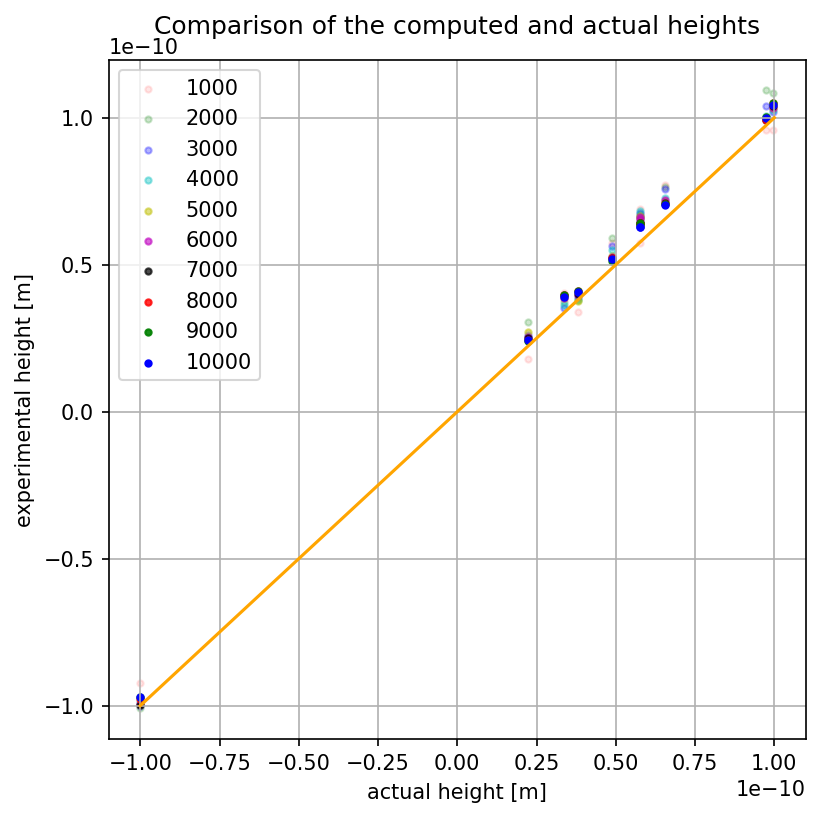

posx and posy should be finite values


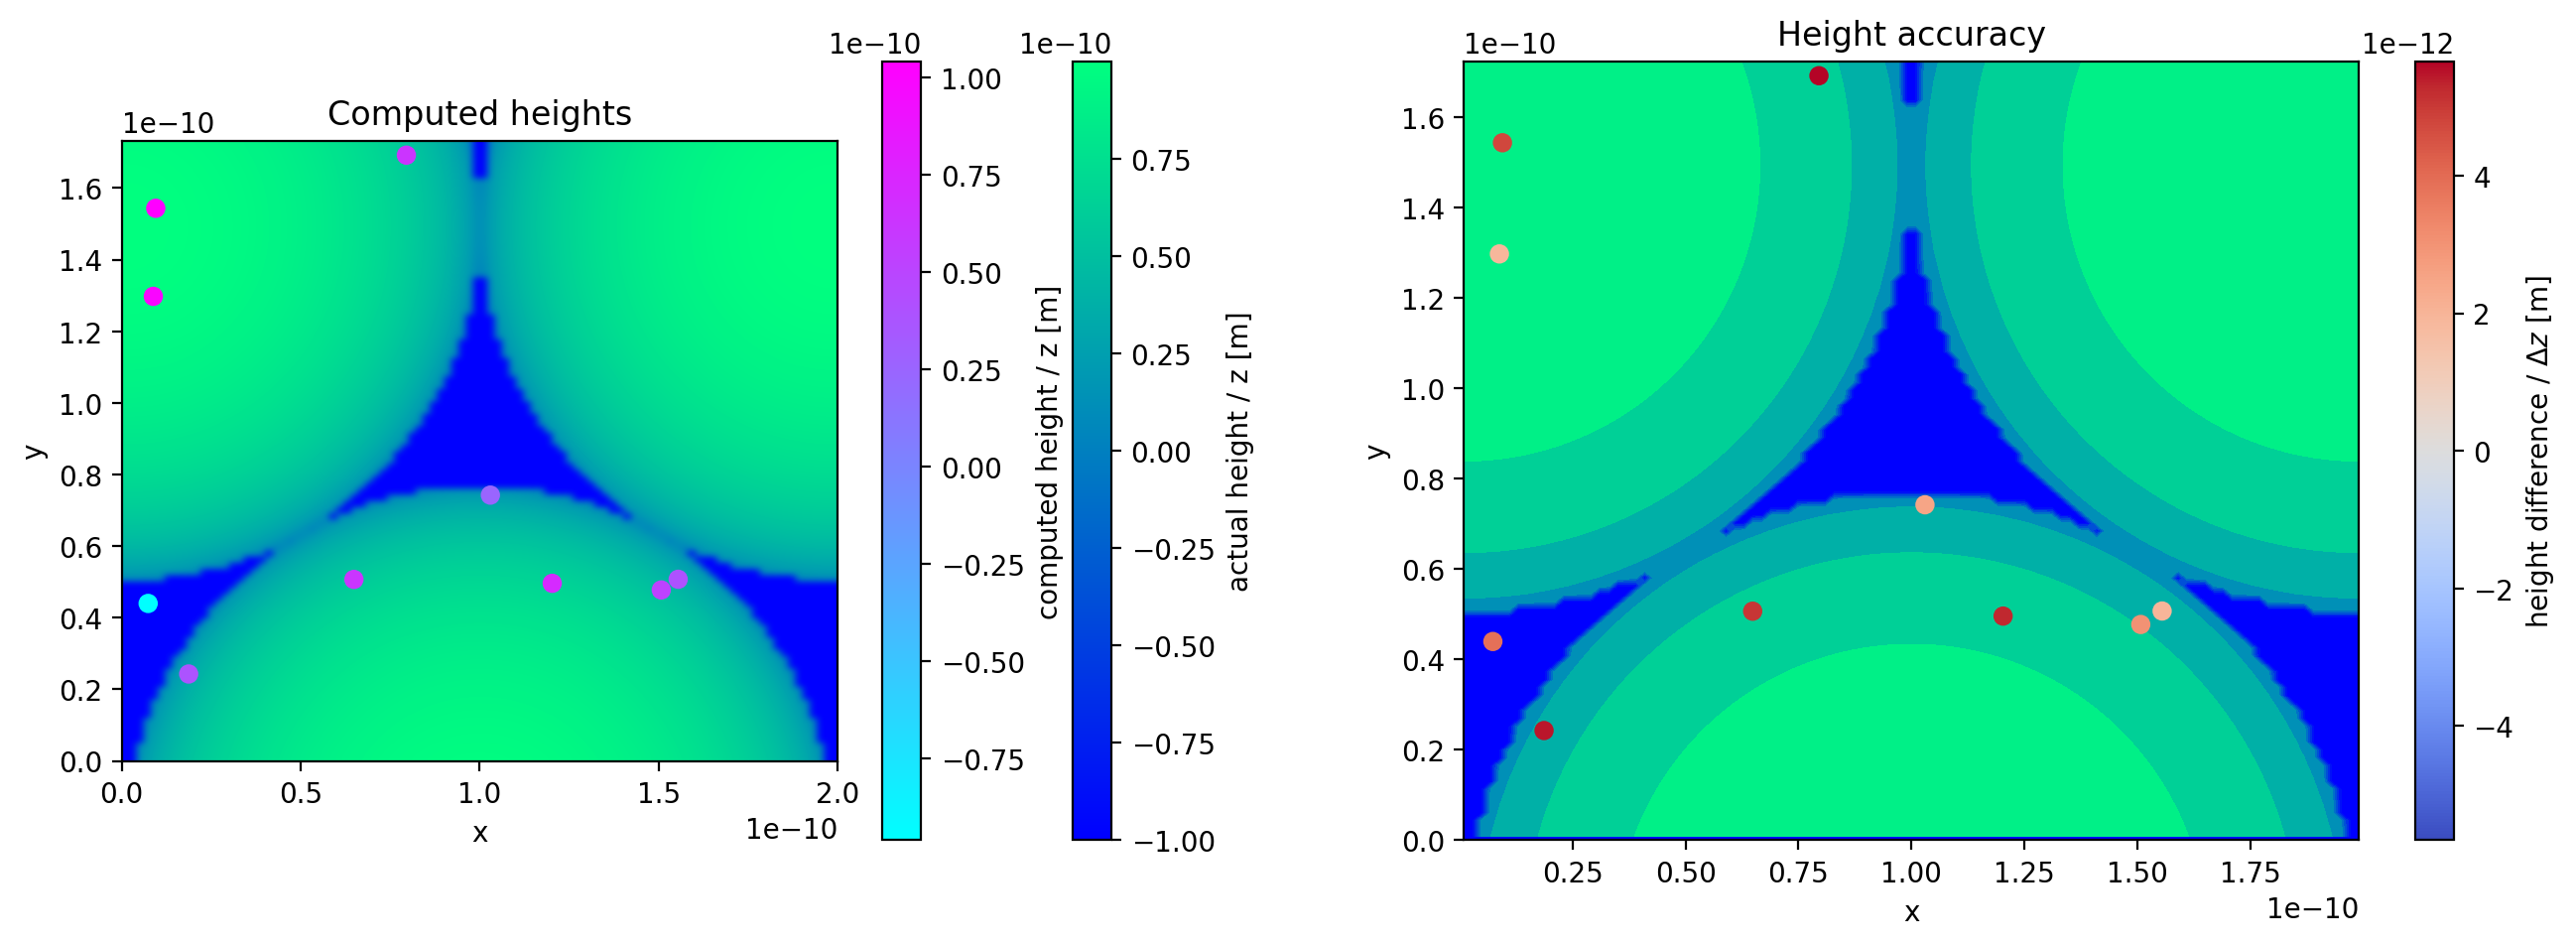

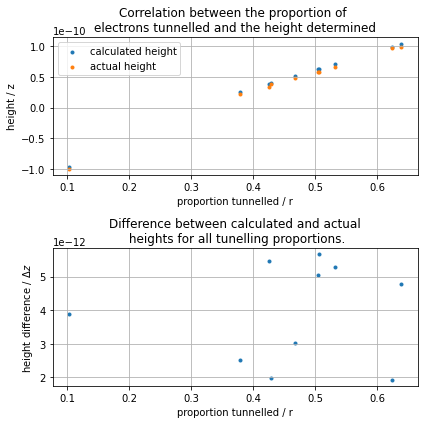

Average absolute difference = (4.0+/-1.4)pm
bias = 3.9577823421353733pm


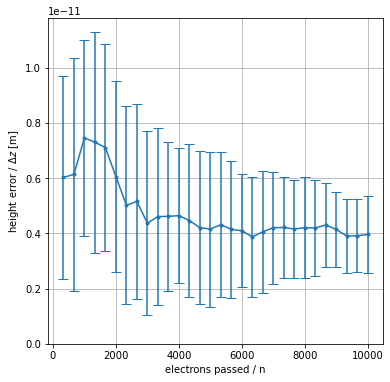

In [6]:
if __name__=='__main__':
    main()